In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
y = np.array([21,20,15])
n = np.array([48,34,21])
Z = np.array([10,30,50])

data_air = np.zeros((3,3))
data_air[:,0] = y
data_air[:,1] = n
data_air[:,2] = Z

print("------------------ Données Air -----------------------")
print(pd.DataFrame(data_air, columns= ["y", "n", "z"]))
print("--------------------------------------------------")

------------------ Données Air -----------------------
      y     n     z
0  21.0  48.0  10.0
1  20.0  34.0  30.0
2  15.0  21.0  50.0
--------------------------------------------------


In [62]:
def gibbs(nchain, data, init_theta, init_x, sd_theta, sd_x, sigma1, sigma2, tau):
    # Chaine pour theta
    chain_theta = np.zeros((nchain + 1, 2)) # theta1, theta2
    chain_theta[0] = init_theta
    # Chaine pour les x_j 
    chain_x = np.zeros((nchain + 1,3)) # x_1, x_2, x_3
    chain_x[0] = init_x
    
    # Nos données
    y = data[:, 0]
    n = data[:, 1]
    z = data[:, 2]
    alpha = 4.48
    beta = .76
    mu = alpha + beta*z # Moyenne des x_j
    
    prob_accep = 0
    
    # MAJ des paramètres
    for i in range(nchain):
        # MAJ theta_1
        theta_candidate = np.random.normal(chain_theta[i,0], sd_theta[0]) # Candidat pour theta_1
        logit_candidate = theta_candidate + chain_theta[i,1]*chain_x[i]
        logit = chain_theta[i,0] + chain_theta[i,1]*chain_x[i]
        
        top = - (theta_candidate**2)/(2*sigma1) - (y*np.log(1+np.exp(-logit_candidate))).sum() - ((n-y)*np.log(1+np.exp(logit_candidate))).sum()
        bottom = - (chain_theta[i,0]**2)/(2*sigma1) - (y*np.log(1+np.exp(-logit))).sum() - ((n-y)*np.log(1+np.exp(logit))).sum()
        ratio = top-bottom
        
        u = np.log(np.random.uniform())
        
        if u < ratio : 
            chain_theta[i+1,0] = theta_candidate
            prob_accep += 1
        else:
            chain_theta[i+1,0] = chain_theta[i,0]
            
            
        # MAJ theta_2
        theta_candidate = np.random.normal(chain_theta[i,1], sd_theta[1]) # Candidat pour theta_1
        logit_candidate = chain_theta[i+1,0] + theta_candidate*chain_x[i]
        logit = chain_theta[i+1,0] + chain_theta[i,1]*chain_x[i]
        
        top = - (theta_candidate**2)/(2*sigma2) - (y*np.log(1+np.exp(-logit_candidate))).sum() - ((n-y)* np.log(1+np.exp(logit_candidate))).sum()
        bottom = - (chain_theta[i,0]**2)/(2*sigma2) - (y*np.log(1+np.exp(-logit))).sum() - ((n-y)*np.log(1+np.exp(logit))).sum()
        ratio = top-bottom
        
        u = np.log(np.random.uniform())
        
        if u < ratio : 
            chain_theta[i+1,1] = theta_candidate
            prob_accep += 1
        else:
            chain_theta[i+1,1] = chain_theta[i,1]
            
        # MAJ des x_j
        logit = chain_theta[i+1,0] + chain_theta[i+1,1]*chain_x[i,:]
        
        for j in range(3):
            x_candidate = np.random.normal(chain_x[i,j], sd_x) # candidat pour chaque x_j
            logit_candidate = chain_theta[i+1, 0] + chain_theta[i+1, 1] * x_candidate
            top = -(x_candidate-mu[j])**2/(2*tau) - y[j]*np.log(1+np.exp(-logit_candidate)) - (n[j]-y[j])*np.log(1+np.exp(logit_candidate))
            bottom = -(chain_x[i,j]-mu[j])**2/(2*tau) - y[j]*np.log(1+np.exp(-logit[j])) - (n[j]-y[j])*np.log(1+np.exp(logit[j]))
            
            ratio = top-bottom
            u = np.log(np.random.uniform())
            
            if u < ratio:
                chain_x[i+1,j] = x_candidate
                prob_accep += 1
            else:
                chain_x[i+1,j] = chain_x[i,j]
    preprocess_vec = np.arange(101000, nchain+1, 10)
    chain_theta = chain_theta[preprocess_vec, :]
    chain_x = chain_x[preprocess_vec, :]
    return chain_theta, chain_x, (prob_accep / (5*nchain))

In [63]:
theta, x_chain, prob_accep = gibbs(121000, data_air, np.array([.5, .5]), np.zeros(3), np.array([2, .05]), 10, 1000, 1000, 81.14)

In [64]:
prob_accep

0.3738925619834711

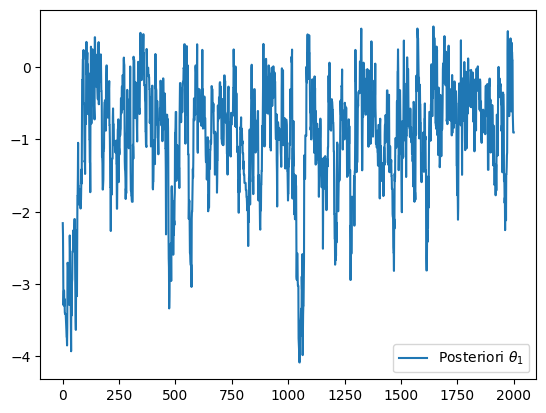

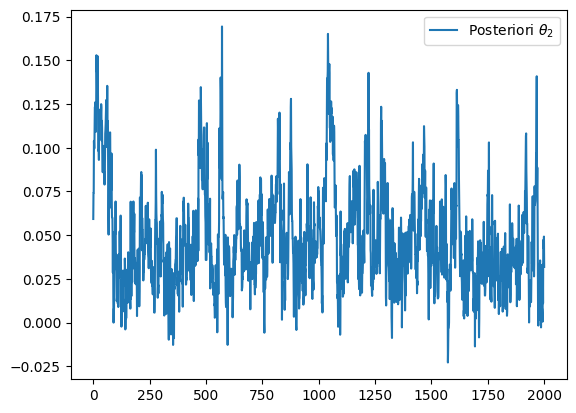

In [65]:
plt.plot(theta[:, 0], label = r'Posteriori $\theta_1$')
plt.legend()
plt.show()
plt.plot(theta[:, 1], label = r'Posteriori $\theta_2$')
plt.legend()

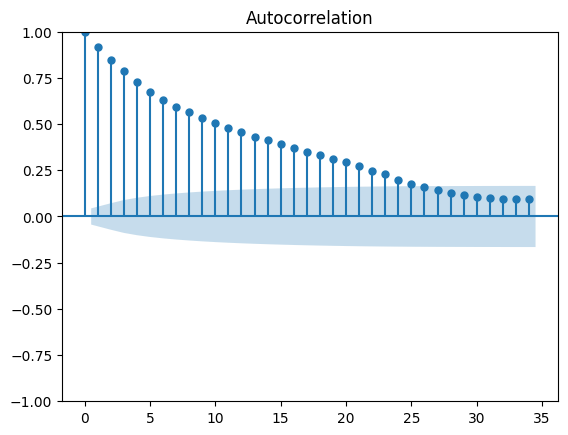

In [66]:
from statsmodels.graphics import tsaplots
autocorr_theta1 = tsaplots.plot_acf(theta[:, 0])

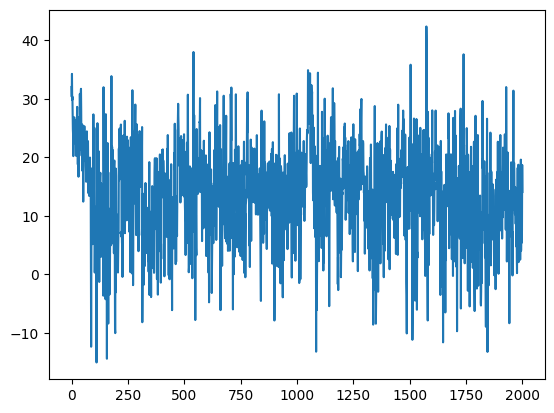

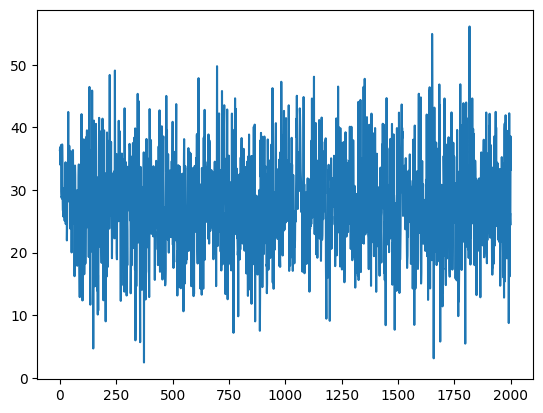

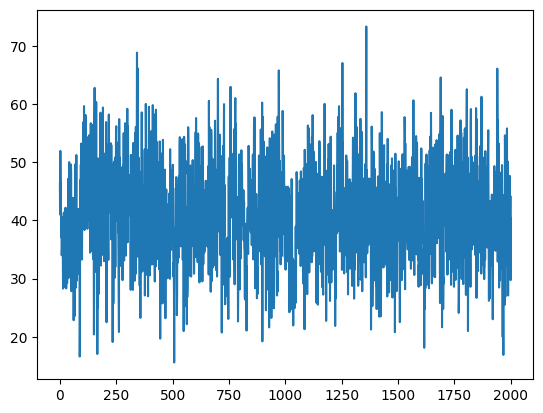

In [67]:
plt.plot(x_chain[:, 0])
plt.show()
plt.plot(x_chain[:, 1])
plt.show()
plt.plot(x_chain[:, 2])
plt.show()

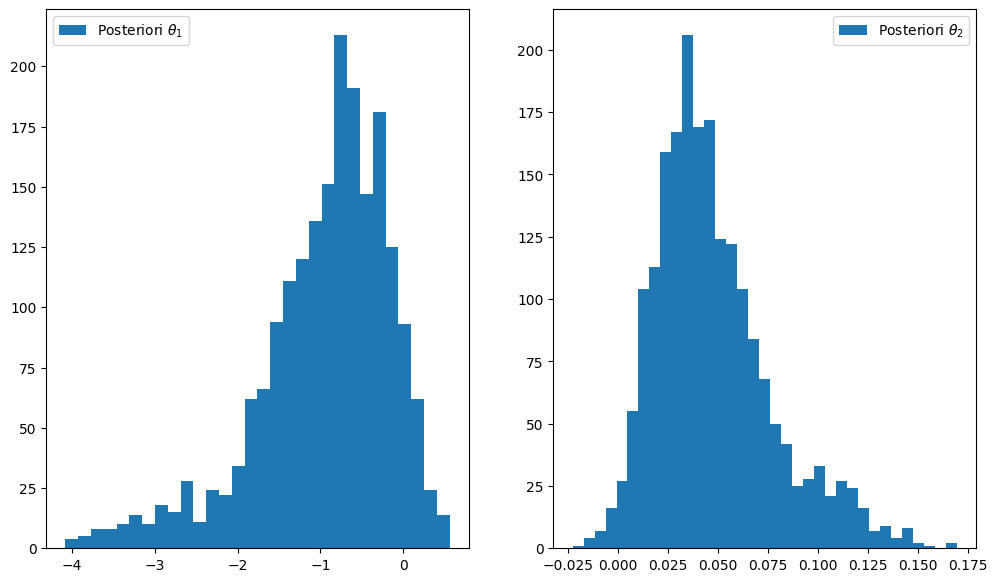

In [68]:
fig, ax = plt.subplot_mosaic([["A","B"]], figsize = (12, 7))
ax["A"].hist(theta[: , 0], bins = "auto", label = r"Posteriori $\theta_1$")
ax["A"].legend()


ax["B"].hist(theta[: , 1], bins = "auto", label = r"Posteriori $\theta_2$")
ax["B"].legend()

In [69]:
#Tableau résumé : statistiques des différents paramètres 
print("-------------------------------------------------------------------------------")
print(f"Estimateur en moyenne de theta1 {round(np.mean(theta[: , 0]), 2)} et variance de la loi a posteriori {round(np.std(theta[: , 0]), 2)}")
print(f"Estimateur en moyenne de theta2 {round(np.mean(theta[: , 1]),2)} et variance de la loi a posteriori {round(np.std(theta[: , 1]),2)}")
print(f"Estimateur en moyenne de X1 {round(np.mean(x_chain[: , 0]),2)} et variance de la loi a posteriori {round(np.std(x_chain[: , 0]),2)}")
print(f"Estimateur en moyenne de X2 {round(np.mean(x_chain[: , 1]),2)} et variance de la loi a posteriori {round(np.std(x_chain[: , 1]),2)}")
print(f"Estimateur en moyenne de X3 {round(np.mean(x_chain[: , 2]),2)} et variance de la loi a posteriori {round(np.std(x_chain[: , 2]),2)}")

-------------------------------------------------------------------------------
Estimateur en moyenne de theta1 -0.95 et variance de la loi a posteriori 0.81
Estimateur en moyenne de theta2 0.05 et variance de la loi a posteriori 0.03
Estimateur en moyenne de X1 13.47 et variance de la loi a posteriori 8.05
Estimateur en moyenne de X2 27.6 et variance de la loi a posteriori 7.39
Estimateur en moyenne de X3 41.03 et variance de la loi a posteriori 8.33
